In [17]:
from ete3 import Tree
import scanpy as sc
import networkx as nx
import numpy as np
import pandas as pd

from collections import defaultdict

import seaborn as sns
import os
import gseapy

import pickle as pic

import scipy.stats as scs

from numba import jit

from tqdm import tqdm_notebook, tqdm

import matplotlib.pyplot as plt

from utilities import de_utils
from utilities import tree_utilities
from utilities import validate_trees as val_tree

import utilities.metastasis_score_utils as met_utils
import statsmodels.stats.multitest as multi

import scipy as sp

from cassiopeia.TreeSolver.Node import Node

# Read in 10X data

In [2]:
path = "/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/RNA/ALL_Samples/GRCh38/"
adata = sc.read(path + "matrix.mtx", cache=True).T
genes = pd.read_csv(path + "genes.tsv", header=None, sep='\t')
adata.var_names = genes[1]
adata.var['gene_ids'] = genes[0]  # add the gene ids as annotation of the variables/genes
adata.obs_names = pd.read_csv(path + 'barcodes.tsv', header=None)[0]
adata.var_names_make_unique()

all_genes = adata.var_names

# meta = pd.read_csv("data/5k.LG_meta.txt", sep='\t', index_col=0)
meta = pd.read_csv("/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/RNA/JQ.5k.vision_meta.txt", sep='\t', index_col = 0)
latent = pd.read_csv("/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/RNA/ALL_Samples/latent.csv", sep='\t', index_col = 0)
latent.index = adata.obs_names

lg_meta = pd.read_csv("/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/RNA/LG_meta.txt", sep='\t', index_col = 0)

umap = pd.read_csv("/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/RNA/ALL_Samples/JQ19.5k.UMAP.txt", sep='\t', index_col = 0)

gene_list = pd.read_csv("/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/RNA/ALL_Samples/filtered_genes.txt", sep='\t', header=None).iloc[:,0].values

sig_scores = pd.read_csv("/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/RNA/JQ19.sigscores.txt", sep='\t', index_col = 0)

keep_cells = np.intersect1d(sig_scores.index, adata.obs_names)
keep_cells = np.intersect1d(keep_cells, adata.obs.index)

meta_filter = list(map(lambda x: x in keep_cells, adata.obs.index.values))
adata = adata[meta_filter, :]

sig_scores_subset = sig_scores.loc[keep_cells]

adata.shape, latent.shape, meta.shape 

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


((35970, 33694), (43423, 10), (35970, 10))

In [3]:
adata.obs = adata.obs.merge(meta, left_index = True, right_index=True, how="left")

meta_filter = np.logical_not(adata.obs["DynamicMetScore"].isna())
adata = adata[meta_filter, :]

latent = latent.loc[adata.obs_names].values

In [4]:
adata.raw = sc.pp.log1p(adata, copy=True)

In [5]:
scale_factor = np.median(np.array(adata.X.sum(axis=1)))
sc.pp.normalize_per_cell(adata, counts_per_cell_after = scale_factor)

In [6]:
filter_result = list(map(lambda x: x in gene_list, adata.var_names))
# sc.pl.filter_genes_dispersion(filter_result)
adata = adata[:, filter_result]

In [7]:
sc.pp.log1p(adata)

/home/eecs/mattjones/.local/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:285: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(data)


In [8]:
adata.obsm["X_umap"] = umap.loc[adata.obs_names]


/home/eecs/mattjones/.local/lib/python3.6/site-packages/anndata/core/alignedmapping.py:162: UserWarning: AnnData does not currently support writing or reading of 'DataFrame' objects in obsm for either hdf5 or zarr formats.
  self._validate_value(value, key)


In [9]:
adata.obs.head(5)

,LineageGroup,sampleID,TS_UMI,NUM_INTBC,Sample2,StaticMetScore,DynamicMetScore,nUMI,nGenes,VISION_Clusters,n_counts
0,,,,,,,,,,,
LL.AAACCTGGTACATGTC-1,46,LL,56,6,LL,0.051434,0.000000,6247,1995,Cluster 1,6080.0
LL.AAACCTGTCAAGGTAA-1,1,LL,81,6,LL,0.779112,0.185814,6247,5637,Cluster 2,38997.0
LL.AAACGGGGTCTTGATG-1,1,LL,168,8,LL,0.779112,0.185814,6247,3743,Cluster 3,17685.0
LL.AAACGGGGTGTTAAGA-1,29,LL,143,10,LL,0.049666,0.000000,6247,2278,Cluster 1,10829.0
LL.AAACGGGTCGTTTAGG-1,4,LL,82,11,LL,0.762563,0.063810,6247,1412,Cluster 4,5052.0


## Look at RNA vs Lineage Consistency

In [ ]:
sc.tl.pca(adata, n_comps=30)

In [11]:
lg10 = pic.load(open("/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/trees/lg19/lg19_tree_hybrid_priors.alleleThresh.processed.pkl", 'rb'))
cm = pd.read_csv("/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/trees/lg19/lg19_character_matrix.alleleThresh.txt", sep='\t', index_col = 0)

lg10data = adata[adata.obs['LineageGroup'] == 19.0]
sc.tl.pca(lg10data, n_comps=30)

samples = lg10data.obs.index.values

/home/eecs/mattjones/.local/lib/python3.6/site-packages/anndata/core/alignedmapping.py:162: UserWarning: AnnData does not currently support writing or reading of 'DataFrame' objects in obsm for either hdf5 or zarr formats.
  self._validate_value(value, key)


In [12]:
def compute_pairwise_edit_dists(cm, samples, verbose=True):

    def compute_hamming_dist(n1, n2):
        
        x_list, y_list = n1, n2
        count = 0
        for i in range(len(x_list)):
            
            if x_list[i] == y_list[i]:
                count += 0
            
            elif x_list[i] == '-' or y_list[i] == '-':
                count += 0
                
            elif x_list[i] == '0' or y_list[i] == '0':
                count += 1
            
            else:
                count += 2
                
        return count
        
    
    dists, pair_names = [], []
    for i in tqdm(range(len(samples))):
        
        for j in range(i+1, len(samples)):
            
            n1, n2 = cm.iloc[i,:], cm.iloc[j,:]
            
            dists.append(compute_hamming_dist(n1, n2))
            pair_names.append((samples[i], samples[j]))
            
    return dists, pair_names

In [13]:
edit_dists, pair_names = compute_pairwise_edit_dists(cm, samples)

100%|██████████| 305/305 [01:48<00:00,  2.82it/s]


In [20]:
lg10data.obsm

AxisArrays with keys: X_umap, X_pca

In [24]:
rna_dists = sp.spatial.distance.pdist(lg10data.obsm['X_pca'], metric = 'euclidean')



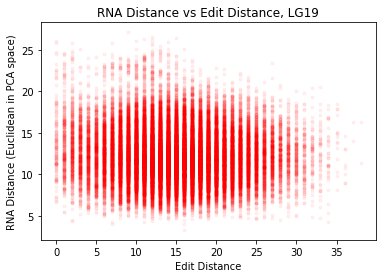

In [27]:
plt.plot(edit_dists, rna_dists, 'r.', alpha = 0.05)
plt.title("RNA Distance vs Edit Distance, LG19")
plt.xlabel('Edit Distance')
plt.ylabel('RNA Distance (Euclidean in PCA space)')
plt.show()

## Look at Dynamics of Gene Expression & Metastastic Score Across Tree

In [177]:
def aggregate_expression(nodes, data, col):
    
    filt = list(map(lambda x: x in nodes, data.obs_names))
    if data[filt,:].shape[0] == 0: 
        return None
    
    # count = np.mean(data.X.todense()[:, (data.var_names == col)][filt, :].ravel())
    count = np.mean(data.X.todense()[filt,:], axis=0)
    return count

def aggregate_signature(nodes, data, col):
    
    filt = np.intersect1d(nodes, data.index.values)
    
    if len(filt) == 0:
        return None
    
    count = np.mean(data.loc[filt, col])
    return count

def run_lin_reg(exprs, var_names, ys):

    pvals = {}
    betas = {}
    corrs = {}

    for gene, j in tqdm(zip(var_names, range(len(var_names))), total = len(var_names)):
        
        ex = [expr[j] for expr in exprs]
        
        # ex = expr[:, j]
        slope, intercept, r_value, p_value, std_err = scs.linregress(ex, ys)

        pvals[gene] = p_value
        betas[gene] = slope
        corrs[gene] = r_value

    return pvals, betas, corrs

In [173]:
lg4data = adata[adata.obs['LineageGroup'] == 2.0]
sc.pp.neighbors(lg4data, n_neighbors = int(np.sqrt(lg4data.X.shape[0])))
sc.tl.louvain(lg4data)
sc.tl.umap(lg4data)

tree = pic.load(open("/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/trees/lg2/lg2_tree_hybrid_priors.alleleThresh.processed.pkl", 'rb')).network

/home/eecs/mattjones/.local/lib/python3.6/site-packages/anndata/core/alignedmapping.py:162: UserWarning: AnnData does not currently support writing or reading of 'DataFrame' objects in obsm for either hdf5 or zarr formats.
  self._validate_value(value, key)


         Falling back to preprocessing with `sc.pp.pca` and default params.


In [174]:
net = tree_utilities.propagate_function_nx(tree, lambda x: met_utils.compute_dynamic_metastasis_score(nx.dfs_tree(tree, source = x), lg_meta['sampleID']), 'MetScore', min_size = 1)
# net = tree_utilities.propagate_function_nx(net, lambda x: aggregate_expression([n.name for n in nx.dfs_tree(net, source=x) if net.out_degree(n) == 0], lg4data, 'SEPP1'), 'SEPP1', min_size=1)
# net = tree_utilities.propagate_function_nx(net, lambda x: aggregate_expression([n.name for n in nx.dfs_tree(net, source=x) if net.out_degree(n) == 0], lg4data, 'B2M'), 'B2M', min_size=1)
net = tree_utilities.propagate_function_nx(net, lambda x: aggregate_expression([n.name for n in nx.dfs_tree(net, source=x) if net.out_degree(n) == 0], lg4data, 'B2M'), 'expression', min_size=1)

# net = tree_utilities.propagate_function_nx(net, lambda x: aggregate_signature([n.name for n in nx.dfs_tree(net, source=x) if net.out_degree(n) == 0], sig_scores, 'XU_AKT1_TARGETS_48HR'), 'AKT', min_size=1)

Propagating function down tree: 100%|██████████| 23892/23892 [10:03<00:00, 39.62it/s]


  0%|          | 0/4005 [00:00<?, ?it/s]/home/eecs/mattjones/.local/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:116: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/eecs/mattjones/.local/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:128: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)
100%|██████████| 4005/4005 [00:01<00:00, 2534.83it/s]


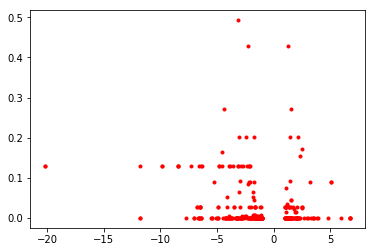

,pvalues,betas,Corr,Adjusted P-values
MOGAT3,0.000080,-3.161065,-0.302982,0.321620
PSMD14,0.000234,0.202464,0.283537,0.337185
RPL32,0.000253,-0.204757,-0.282101,0.337185
CLU,0.000540,0.075447,0.267284,0.372581
CDHR2,0.000456,1.302857,0.270678,0.372581
BX470102.3,0.000558,-2.243871,-0.266634,0.372581
IL4I1,0.001954,1.498591,0.240129,0.536695
C12orf75,0.002278,0.062872,0.236686,0.536695
RPL24,0.002091,-0.124239,-0.238620,0.536695
NPC1L1,0.001425,-4.420250,-0.247084,0.536695


In [180]:
exprs, ys = [], []
for n in net:
    if type(net.nodes[n]['expression']) == np.matrix and net.nodes[n]['MetScore'] > 0:
        exprs.append([e for e in net.nodes[n]['expression'].flat])
        ys.append(net.nodes[n]['MetScore'])

pvals, betas, corrs = run_lin_reg(exprs, lg4data.var_names, ys)

genedf = pd.DataFrame.from_dict(pvals, orient="index", columns=['pvalues'])
genedf["betas"] = list(map(lambda x: betas[x], pvals.keys()))
genedf["Corr"] = list(map(lambda x: corrs[x], pvals.keys()))
genedf["Adjusted P-values"] = multi.multipletests(genedf["pvalues"], alpha=0.05, method='fdr_bh')[1]

cleaned = genedf[np.abs(genedf['betas']) > 1]
# plt.plot(genedf.loc[genedf['betas'] > 1], -np.log10(genedf['Adjusted P-values']), 'r.')
plt.plot(cleaned['betas'],-np.log10(cleaned['Adjusted P-values']), 'r.')
plt.show()

genedf.sort_values(by="Adjusted P-values", ascending=True).head(40)


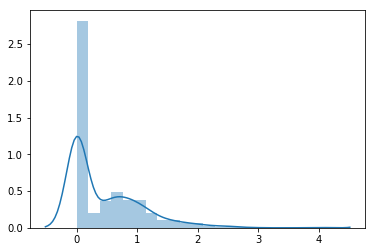

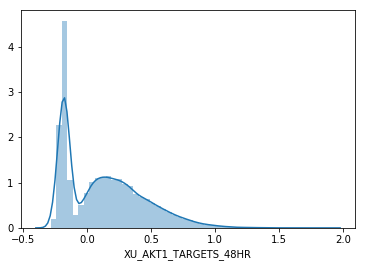

In [64]:
sns.distplot(lg4data.X[:,(lg4data.var_names == 'IFI6')].todense()[:,0])
plt.show()

sns.distplot(sig_scores['XU_AKT1_TARGETS_48HR'])
plt.show()


In [73]:
n = [n for n in net][10]
net.nodes[n]['expression'].shape

(1, 4005)

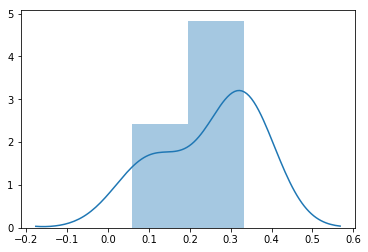

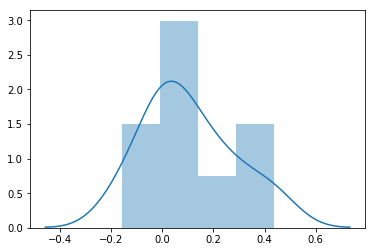

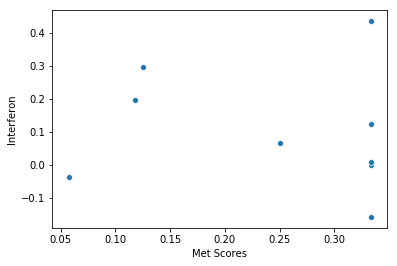

In [62]:
ms, gs = [], []
for n in net:
    if net.nodes[n]['IFI6'] != None and net.nodes[n]['MetScore'] > 0:
        ms.append(net.nodes[n]['MetScore'])
        gs.append(net.nodes[n]['AKT'])

# met_scores = [net.nodes[n]['MetScore'] for n in net]
#ms = [m for m in met_scores if m != None]
sns.distplot(ms)
plt.show()

# ifi6 = [net.nodes[n]['InterferonSignature'] for n in net]
#gs = [m for m in ifi6 if m!= None]
sns.distplot(gs)
plt.show()

# print(len(ms), len(gs))

sns.scatterplot(ms, gs)
plt.xlabel("Met Scores")
plt.ylabel("Interferon")
plt.show()

... storing 'selection' as categorical


<Figure size 504x504 with 0 Axes>

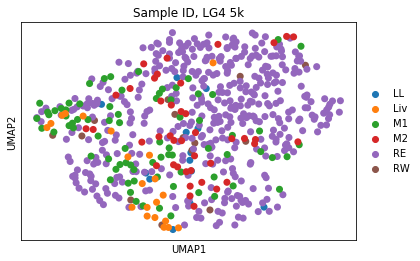

<Figure size 504x504 with 0 Axes>

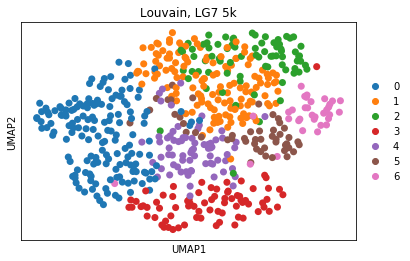

['0' '1']
(603, 2)


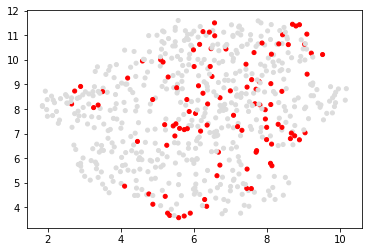

In [68]:
nodes = [n for n in net if net.nodes[n]['InterferonSignature'] != None and net.nodes[n]['AKT'] > 0.3]
leaves = []

for n in nodes:
    leaves += [v.name for v in net.successors(n) if net.out_degree(v) == 0]
    

h = plt.figure(figsize = (7,7))
ax = sc.pl.umap(lg4data, color = "sampleID", show = False)
plt.title("Sample ID, LG4 5k")
plt.show()

h = plt.figure(figsize = (7,7))
ax = sc.pl.umap(lg4data, color = "louvain", show = False)
plt.title("Louvain, LG7 5k")
plt.show()


lg4data.obs['selection'] = lg4data.obs.apply(lambda x: '1' if x.name in leaves else '0', axis=1)
print(lg4data.obs['selection'].unique())
cmapping = {'1': 'red', '0': '#DCDCDC'}
print(lg4data.obsm['X_umap'].shape)
plt.scatter(lg4data.obsm['X_umap'][:,0], lg4data.obsm['X_umap'][:,1], s=10000 / lg4data.shape[0], c = [cmapping[x] for x in lg4data.obs['selection']])

# Compute Indel Enrichment in each Cluster

In [11]:
lg3data = adata[adata.obs['LineageGroup'] == 3.0]
sc.pp.neighbors(lg3data, n_neighbors = int(np.sqrt(lg3data.X.shape[0])))
sc.tl.louvain(lg3data)
sc.tl.umap(lg3data)

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [12]:
def compute_cluster_enrichment(cluster_ids, values, col):
    
    uniq_clust = np.unique(cluster_ids.values)
    uniq_values = np.unique(values.values)
    
    counts = np.zeros((len(uniq_clust), len(uniq_values)))
    
    for i in range(len(uniq_clust)):
        clust = cluster_ids[cluster_ids == uniq_clust[i]].index.values
        sub_vals = values.loc[clust]
        for j in range(len(uniq_values)):
            val = uniq_values[j]
            counts[i, j] = len(np.where(sub_vals.values == val)[0])
            
    counts = pd.DataFrame(counts)
    counts.index = uniq_clust
    counts.columns = uniq_values
    
    # look for enrichments for each value
    for value in counts.columns:
        tot_counts = counts.loc[:,value].sum()
        bg = [tot_counts / counts.shape[0]] * counts.shape[0]
        rs = scs.ranksums(counts.loc[:,value].values, bg)
        
        if rs[1] < (0.05) and tot_counts > 100:
            print(col, value, tot_counts)
    
    return counts
        

In [14]:
lineage_profile = pd.read_csv("../JQ19/5k/trees/lg3/lg3_X.txt", sep='\t', index_col = 0, dtype=str)
lineage_profile = lineage_profile.fillna('Missing')
lineage_profile = lineage_profile.iloc[2:,:]
lineage_profile.index.name = 'cellBC'

# lg2data.obs = lg2data.obs.merge(lineage_profile, left_index = True, right_index=True, how="left")
clusters = lg3data.obs['louvain']



TCGCATTCACATCC


100%|██████████| 51/51 [00:08<00:00,  7.13it/s]


<Figure size 720x720 with 0 Axes>

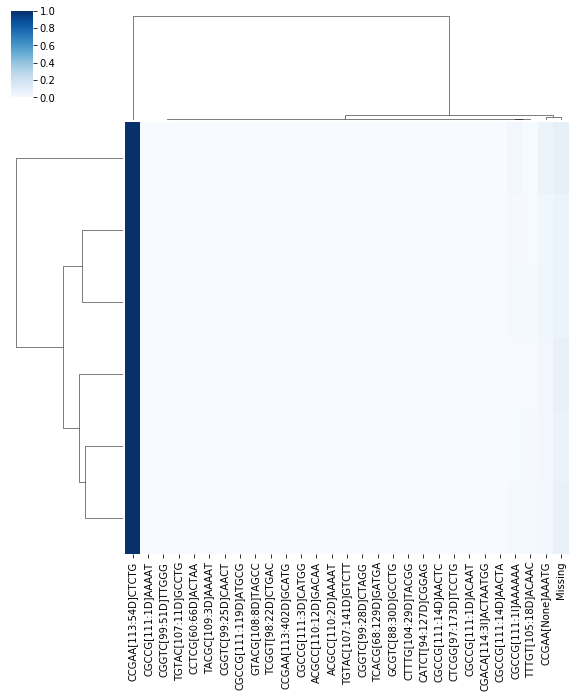

In [16]:
col = lineage_profile.columns[0]
print(col)
indel_counts = compute_cluster_enrichment(clusters, lineage_profile[col], col)
h = plt.figure(figsize = (10, 10))
sns.clustermap(indel_counts, cmap = 'Blues', yticklabels = False, standard_scale=2)
for col in tqdm(lineage_profile.columns):
    indel_counts = compute_cluster_enrichment(clusters, lineage_profile[col], col)
# h = plt.figure(figsize = (10, 10))
# sns.clustermap(indel_counts, cmap = 'Blues', yticklabels = False, standard_scale=2)

['0' '1']
(7525, 2)


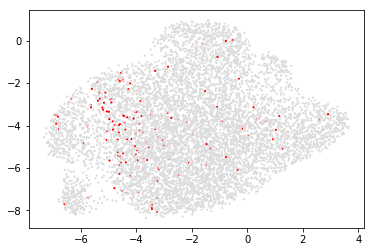

In [208]:
lg2data.obs['selection'] = lg2data.obs.apply(lambda x: '1' if x['GCGCTCCCTATGAT.2'] == 'TAATT[219:14D]CGGTT' else '0', axis=1)
print(lg2data.obs['selection'].unique())
cmapping = {'1': 'red', '0': '#DCDCDC'}
print(lg2data.obsm['X_umap'].shape)
plt.scatter(lg2data.obsm['X_umap'][:,0], lg2data.obsm['X_umap'][:,1], s=10000 / lg2data.shape[0], c = [cmapping[x] for x in lg2data.obs['selection']])

# Read in tree & compute some statistics over flattened tree

### Find cluster membership of each clade

In [17]:
def assign_labels(tree, meta):
    
    for v in tree.get_leaves():
        if v.name in meta.index:
        
            v.add_feature('meta', meta[v.name])

        else:
            v.add_feature('meta', "None")
    return tree

def get_meta_props(tree):
    
    counts = defaultdict(int)
    for l in tree.get_leaves():
        if l.meta == 'None':
            continue
        counts[l.meta] += 1
        
    #renormalize
    tot = np.sum([s for s in counts.values()])
    for i in counts.keys():
        counts[i] /= tot
        
    return counts

def rename_tree(tree):
    
    seen = []
    i = 0
    for v in tree.traverse():
        
        if v.name in seen:
            v.name = 'node' + str(i)
            i += 1
            
    return tree
    


In [18]:
lg2data = adata[adata.obs['LineageGroup'] == 3]
sc.pp.neighbors(lg2data, n_neighbors = int(np.sqrt(lg2data.X.shape[0])))
sc.tl.louvain(lg2data)
sc.tl.umap(lg2data)

tree = Tree("/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/trees/lg3/lg3_tree_hybrid_priors.processed.txt", 1)
tree = rename_tree(tree)
tree = assign_labels(tree, lg2data.obs['louvain'])

tree = tree_utilities.progagate_function(tree, lambda x: get_meta_props(x), 'cluster_count', min_size = 100)

cm = pd.read_csv("/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/trees/lg3/lg3_character_matrix.txt", sep='\t', index_col = 0)

/home/eecs/mattjones/.local/lib/python3.6/site-packages/anndata/core/alignedmapping.py:162: UserWarning: AnnData does not currently support writing or reading of 'DataFrame' objects in obsm for either hdf5 or zarr formats.
  self._validate_value(value, key)


         Falling back to preprocessing with `sc.pp.pca` and default params.


... storing 'sampleID' as categorical
... storing 'Sample2' as categorical
... storing 'VISION_Clusters' as categorical
... storing 'gene_ids' as categorical


<Figure size 720x720 with 0 Axes>

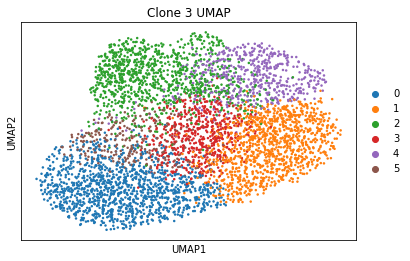

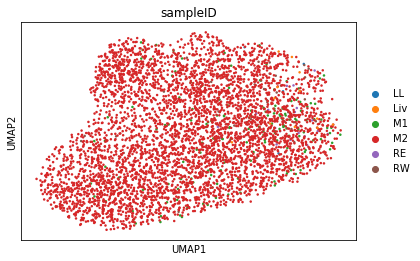

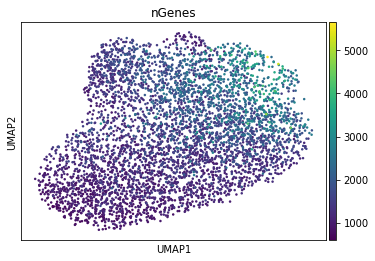

In [19]:
h = plt.figure(figsize = (10, 10))
ax = sc.pl.umap(lg2data, color = 'louvain', show=False)
plt.title('Clone 3 UMAP')
plt.savefig("figs/lg3_umap.pdf", bbox_inches='tight')

sc.pl.umap(lg2data, color='sampleID')
sc.pl.umap(lg2data, color = 'nGenes')


[5, 4, 1, 0, 3, 2]
Categories (6, object): [5, 4, 1, 0, 3, 2]


<Figure size 720x720 with 0 Axes>

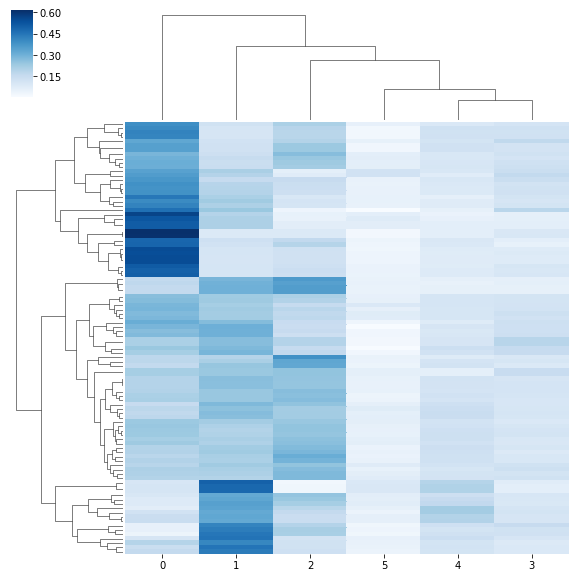

In [39]:
i = 0
k = '1'
meta_vals = []

for l in tqdm_notebook(tree.get_leaves()):
    
    path = []
    node = l
    while node.up:
        try:
            path.append(node.cluster_count[k])
            node= node.up
        except:
            node= node.up
            continue
        
        
    meta_vals.append(path)

summ_dict = {}
keys = lg2data.obs['louvain'].unique()
print(keys)
for v in tree.traverse():
    try:
        summ_dict[v.name] = [v.cluster_count[k] for k in keys]
    except:
        continue
        
summ_df = pd.DataFrame.from_dict(summ_dict, orient='index')
summ_df.columns = keys

h = plt.figure(figsize = (10, 10))
sns.clustermap(summ_df, cmap = 'Blues', yticklabels = False)

interesting_paths = []
for v in tree.traverse():
    try:
        if v.cluster_count['2'] > 0.35:
            node = v
            path = []
            while node.up:
                path.append(node)
                node = node.up
            interesting_paths.append(path[::-1])
    except:
        continue

In [40]:
len(interesting_paths)

4

['0' '1']


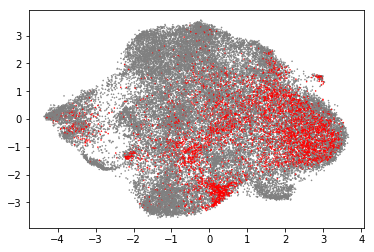

In [29]:
adata.obs['selection'] = adata.obs.apply(lambda x: '1' if x.LineageGroup == 3 else '0', axis=1)
print(adata.obs['selection'].unique())
cmapping = {'1': 'red', '0': 'grey'}
plt.scatter(adata.obsm['X_umap']['UMAP-1'], adata.obsm['X_umap']['UMAP-2'], s=10000 / adata.shape[0], c = [cmapping[x] for x in adata.obs['selection']])

4
6
0


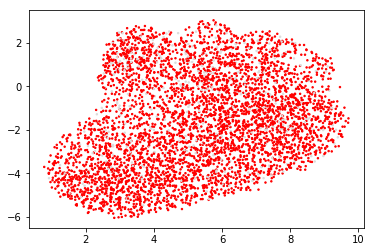

1


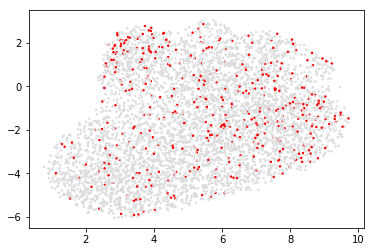

2


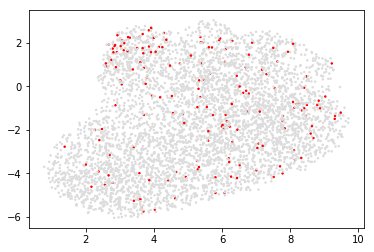

3


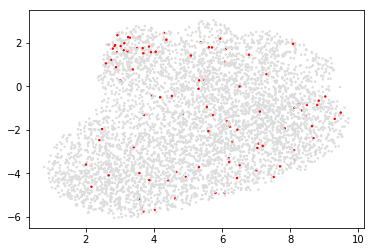

4


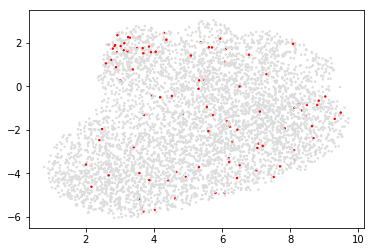

5


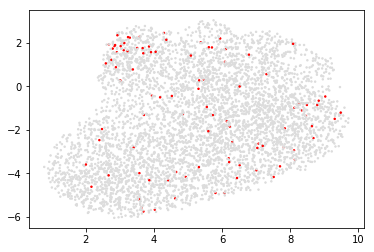

In [44]:
def get_mutations(parent, child):
    
    muts = []
    parent_vec, child_vec = parent.name.split("_")[0].split("|"), child.name.split("_")[0].split("|")
    
    for i in range(len(parent_vec)):
        
        if parent_vec[i] == '0' and child_vec[i] != '0':
            muts.append((i, child_vec[i]))
            
    return muts

def get_cells_by_indel(muts, cm):
    
    cmp = cm.copy()
    for mut in muts:
        
        cmp = cmp[cmp.iloc[:,mut[0]] == mut[1]]
    return cmp.index.values

def get_mutations_singular(node):
    
    muts = []
    vec = node.name.split("_")[0].split("|")
    for i in range(len(vec)):
        if vec[i] != '0':
            muts.append((i, vec[i]))
            
    return muts


print(len(interesting_paths))
path = interesting_paths[3]
print(len(path))

all_indels = []
for i in range(len(path)):
    p = path[i]
    print(i)
    if i < 1:
        indels = get_mutations_singular(p)
        all_indels += indels
        children = list(get_cells_by_indel(all_indels, cm))
        children += p.get_leaf_names()
        
    else:
        try:
            #indels = get_mutations(path[i-1], path[i])
            #all_indels += indels
            #children = list(get_cells_by_indel(all_indels, cm))
            children = p.get_leaf_names()
        except:
            print('here')
        
    lg2data.obs['selection'] = lg2data.obs.apply(lambda x: '1' if x.name in children else '0', axis=1)
    cmapping = {'1': 'red', '0': 'gainsboro'}
    plt.scatter(lg2data.obsm['X_umap'][:,0], lg2data.obsm['X_umap'][:,1], s=10000 / lg2data.shape[0], c = [cmapping[x] for x in lg2data.obs['selection']])
    # plt.savefig("figs/lg1_trav2_" + str(i) + '.pdf', bbox_inches='tight')
    plt.show()